# Monte Carlo Integrator 

In this notebook I develop a structure to integrate the likelihood over $\lambda, \xi, M$ in a monte carlo setup.

## What is Monte Carlo Integration

Basically instead of integrating over an uniform spaced vector you use random numbers. The output is simply the sum of function evaluated at the random numbers.

### Example:
A simple examples is the one dimension case, given a function $f(x)$ with a probability distribution $p(x)$ the integral over an interval $[a,b]$ is:
$$
I = \int_{a}^{b} f(x) p(x) dx \approx \frac{1}{N}\sum_i^{N}{f(x_i)}
$$

For a significant number of points the integral will converge to the actual area under of the curve. 

## In our case

Our likelihood function is function of $(\lambda, \xi, M)$ and for each variable we have a probility density function associated. 
$$
\text{likelihood}(\lambda, \zeta, M) = \int d\lambda \int d\zeta \int dM \left[ \text{Normal}(\lambda, \zeta, M |\theta)\, p(\lambda|\hat{\lambda})\, p(\zeta|\xi)\, p(M)\right]
$$

The normal function is basically the multivariate gaussian likelihood. The probabilty functions will be used to draw the random numbers ($\lambda_i, \xi_i, M_i$). The halo mass priobility actually needs to be further defined. Currently, we use the halo mass function as a prior, but we can actually define the probability as:
$$
p(M|\zeta) = \int dM P(\zeta|M) P(M) = \int dM \exp{\left[-\frac{1}{2} \left(\frac{\ln{\zeta} - (A_\zeta+B_\xi M) }{\sigma_\zeta}\right)^2 \right] HMF(M) }
$$

Which is the actual probability of $M$ given the SZ relation $\xi$. The issue is that we're fitting the SZ relation altough we have strong priors on the parameters. In the end, the halo mass probability will be drawn for a given $\xi$ and $A_\xi, B_\xi, C_\xi$ and $\sigma_\xi$.

After we draw the random numbers from the probability functions the integral is simply:
$$
\text{likelihood}(\lambda, \xi, M) = \frac{1}{N}\sum_i^{N}{\text{Normal}(\lambda_i, \zeta_i, M_i|\theta)}
$$

We defined this approach for a given cluster, i.e. observed values $z, \hat{\lambda}, \xi$. The probabilities are shaped by this values.

The final likelihood is the same of each cluster likelihod.

More info: https://boyangzhao.github.io/posts/monte-carlo-integration

# Implementation

Now, I'll start to setup this integrator.

## Likelihood Function

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.cosmology import WMAP9 as cosmo
from colossus.cosmology import cosmology
cosmology.setCosmology('WMAP9')

# The Hubble constant at z=0
H0 = cosmo.H(0).value
def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    return (Hz/H0)
M0 = 3e14
Ez0 = E(0)
def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return (np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0)))

def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return (np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0)))

def to_zeta(xi):
    return np.sqrt(xi**2-3)

def to_xi(zeta):
    return np.sqrt(zeta**2+3)

In [2]:
def prediction(theta, M, z):
    """Predicts \\ln{\\lambda),\\ln{\\xi}$ for a given set of parameters values
    """
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]

    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], M, z)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], M, z)

    return np.c_[ln_lbd_pred, ln_zeta_pred]


In [3]:
# Defines the inverse of the covariance matrix for the two dimensional case
# https://online.stat.psu.edu/stat505/book/export/html/636
def get_cinv(s1, s2, rho):
    factor = (s1**2)*(s2**2)*(1-rho**2)
    return factor, np.array([[s1**2, -rho*s1*s2],[-rho*s1*s2, s2**2]])/factor

In [4]:
def likelihood(M, z, theta, x1, x2):
    y = np.c_[x1,x2]
    ypred = prediction(theta, M, z)

    s1, s2, rho = theta[3], theta[6], theta[7]
    norm, cinv = get_cinv(s1, s2, rho)

    # compute likeliihod
    delta = (np.log(y)-ypred).T
    log_like = -0.5*np.diag(np.dot(delta.T,np.matmul(cinv,delta))) + np.log(1/(2*np.pi*np.sqrt(norm)))
    return log_like
# return the log likelihood


### Testing Values

In [5]:
# set some initial parameteres 
_theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]
_M = 4e14 # log mass
_z = 0.5 # redshift

_lbd, _zeta = np.exp(prediction(_theta, _M, _z)).T
_xi = to_xi(_zeta)

# errors
_lbd_err = 10**(0.1*np.log10(_lbd))
_zeta_err = 10**(0.04*np.log10(_zeta))

print('Initial variables')
print('lambda, zeta = %i, %.1f'%(_lbd[0], _zeta[0]))

Initial variables
lambda, zeta = 111, 9.2


In [6]:
get_cinv(0.16, 0.16, 1.0)

/tmp/ipykernel_51214/1844124668.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return factor, np.array([[s1**2, -rho*s1*s2],[-rho*s1*s2, s2**2]])/factor


(0.0,
 array([[ inf, -inf],
        [-inf,  inf]]))

In [7]:
# repeat the vectors npoints
npoints=1
x1 = np.tile(_lbd,npoints)
x2 = np.tile(_zeta,npoints)

# x2[0] *=3

M = np.tile(_M,npoints)
z = np.tile(_z,npoints)
theta = _theta

In [8]:
likelihood(M, z, theta, x1, x2)

array([1.23931489])

In [9]:
## showing the convergence
## change the input value from -20% up to 20%
perc_change = np.linspace(-20,20,100)

likes = []
for p in perc_change:
    likes.append(likelihood(M, z, theta, x1*(1+p/100), x2*(1+p/100)))

Text(0.5, 1.0, 'Likelihood: $\\lambda, \\zeta = 111, 9.19$')

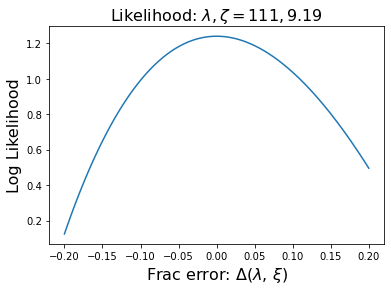

In [10]:
# given the true values, mass and redshift
# plot the likelihood around the true y-values (lambda, zeta)

plt.plot(perc_change/100, likes)
plt.xlabel(r'Frac error: $\Delta(\lambda$, $\xi )$',fontsize=16)
plt.ylabel('Log Likelihood',fontsize=16)
plt.title(r'Likelihood: $\lambda, \zeta = %i, %.2f$'%(_lbd, _zeta),fontsize=16)

## Mass Probability

In [11]:
from colossus.lss import mass_function
def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
halo_mass_function = np.vectorize(_halo_mass_function)

Nmass = 500
mvec = np.logspace(13.8, 15.6, Nmass)

In [12]:
def gaussian(x,mu,std):
    return np.exp(-(x-mu)**2/std**2/2.)/np.sqrt(2*np.pi*std**2)

def prob_mass(zeta, z, theta_sze):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    ln_zeta_pred = ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mvec, z)
    prob_zeta = gaussian(ln_zeta_pred, np.log(zeta)[:,np.newaxis], scatter_sze)
    p_mass = (halo_mass_function(mvec, z)*prob_zeta)
    p_mass = (p_mass).T
    return p_mass

Text(0.5, 1.0, 'Halo Mass Prob: $P(M|\\, \\zeta, \\theta_{SZ})$')

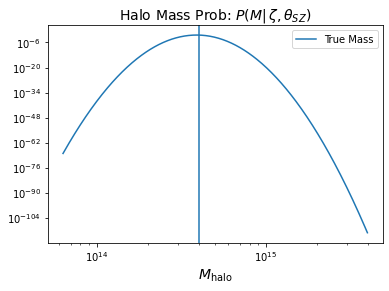

In [13]:
p_mass = prob_mass(_zeta, _z, theta[:4])
plt.loglog()
plt.plot(mvec, p_mass)
plt.axvline(_M,label='True Mass')
plt.legend()
plt.xlabel(r'$M_{\rm halo}$',fontsize=14)
plt.title(r'Halo Mass Prob: $P(M|\, \zeta, \theta_{SZ})$',fontsize=14)

## Monte Carlo Integrator

Our task now is to draw random samples based on the probabilties of each variable, $P_\lambda, P_\zeta, P_M$

In [14]:
def draw_lambda_values(x_obs, x_err, size=1000):
    return 10**(np.log10(x_obs)+np.log10(x_err)*np.random.normal(size=size))

def draw_zeta_values(x_obs, x_err, size=1000):
    return to_zeta(x_obs)+x_err*np.random.normal(size=size)


In [15]:
def draw_mass_values(zeta_mc, z, theta_sze):
    mm = np.logspace(13.4, 15.7, zeta_mc.size)
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    ln_zeta_pred = ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mm, z)
    prob_zeta = gaussian(ln_zeta_pred, np.log(zeta_mc)[:,np.newaxis], scatter_sze)
    p_mass = halo_mass_function(mm, z)*prob_zeta
    m_mc = np.array([np.log10(np.random.choice(mm,p=p_mass[i]/np.sum(p_mass[i]))) for i in range(zeta_mc.size)])
    return m_mc



### Draw a 1000 points 

Text(0.5, 1.0, 'Mass Distribution')

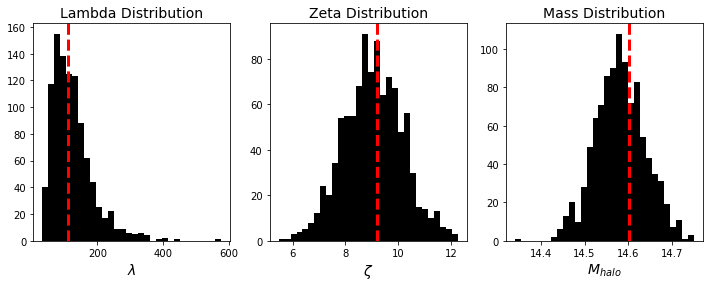

In [16]:
plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
_ = plt.hist(draw_lambda_values(_lbd, _lbd_err),bins=30,color='k')
plt.axvline(_lbd,lw=3,color='r',ls='--')
plt.xlabel(r'$\lambda$',fontsize=14)
plt.title('Lambda Distribution',fontsize=14)

plt.subplot(1, 3, 2)
zeta_mc=draw_zeta_values(_zeta, _zeta_err)
_ = plt.hist(draw_zeta_values(_zeta, _zeta_err),bins=30,color='k')
plt.axvline(_zeta,lw=3,color='r',ls='--')
plt.xlabel(r'$\zeta$',fontsize=14)
plt.title('Zeta Distribution',fontsize=14)

plt.subplot(1, 3, 3)
_ = plt.hist(draw_mass_values(zeta_mc, z, theta[:4]),bins=30,color='k')
plt.axvline(np.log10(_M),lw=3,color='r',ls='--')
plt.xlabel(r'$M_{halo}$',fontsize=14)
plt.title('Mass Distribution',fontsize=14)


### Compute the integral

In [17]:
# compute the integral
zmc = draw_zeta_values(_zeta, _zeta_err)
lmc = draw_lambda_values(_lbd, _lbd_err)
mmc = draw_mass_values(zmc, z, theta[:4])
integral = np.mean(likelihood(mmc, _z, _theta, lmc, zmc))
integral

-45361.820276049824

In [18]:
def mc_likelihood(theta, z, lbd, zeta, lbd_err, zeta_err, Npoints=1000):
    zmc = draw_zeta_values(zeta, zeta_err, size=Npoints)
    lmc = draw_lambda_values(lbd, lbd_err, size=Npoints)
    mmc = 10**draw_mass_values(zmc, z, theta[:4])
    integral = np.mean(likelihood(mmc, z, theta, lmc, zmc))
    return integral

In [19]:
zmc = draw_zeta_values(_zeta, _zeta_err)
lmc = draw_lambda_values(_lbd, _lbd_err)
mmc = 10**draw_mass_values(zmc, _z, theta[:4])
integral = np.mean(likelihood(mmc, _z, theta, lmc, zmc))
integral

-0.6694633532629306

In [20]:
# repeat the vectors npoints
npoints=1
x1 = np.tile(_lbd,npoints)
x2 = np.tile(_xi,npoints)

x1_err = np.tile(_lbd_err,npoints)
x2_err = np.tile(_zeta_err,npoints)


M = np.tile(_M,npoints)
z = np.tile(_z,npoints)
theta = _theta

In [21]:
## showing the convergence
## change the input value from -20% up to 20%
perc_change = np.linspace(-20,20,50)

likes = []
for p in perc_change:
    likes.append(mc_likelihood(theta, z, x1*(1+p/100), x2*(1+p/100), x1_err, x2_err))

On my local computer 100 points takes 10s for Npoints=1000

Text(0.5, 1.0, 'Likelihood: $\\lambda, \\zeta = 111, 9.19$')

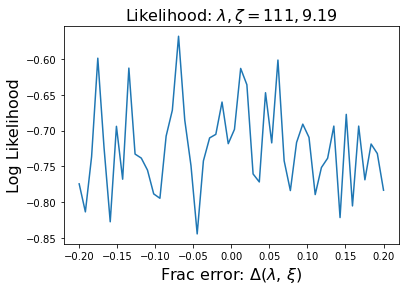

In [22]:
# given the true values, mass and redshift
# plot the likelihood around the true y-values (lambda, zeta)

plt.plot(perc_change/100, likes)
plt.xlabel(r'Frac error: $\Delta(\lambda$, $\xi )$',fontsize=16)
plt.ylabel('Log Likelihood',fontsize=16)
plt.title(r'Likelihood: $\lambda, \zeta = %i, %.2f$'%(_lbd, _zeta),fontsize=16)

We see the convergence trend, however we have a noisy measurment of the integral. 

## Next Steps

The next step is to check the convergence. For a given lambda, zeta, z, theta:
- Compute integral as a function of Npoints.
- Vary the Npoints in logspace from 10 up to 100,000.
- See how the convergence is affected by low and high lambda values.
- Check the same for zeta.

In [23]:
#npoints = np.array([10, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000])
# ORIGINAL: (BASED OFF OF GRAPH LAST TWO NPOINT VALUES SEEM TO HAVE AN ERROR:
# npoints = np.array([10, 100, 200, 500, 1000, 2000, 5000, 10000, 2000, 5000])
npoints = np.array([10, 20, 50, 70, 100, 200, 500, 700, 1000, 2000, 5000, 7000, 10000, 20000])
npoints

array([   10,    20,    50,    70,   100,   200,   500,   700,  1000,
        2000,  5000,  7000, 10000, 20000])

In [24]:
## showing the convergence
likes = []
for nsize in npoints:
    likes.append(mc_likelihood(theta, z, x1, x2, x1_err, x2_err, Npoints=nsize))

Text(0.5, 1.0, 'Likelihood: $\\lambda, \\zeta = 111, 9.19$')

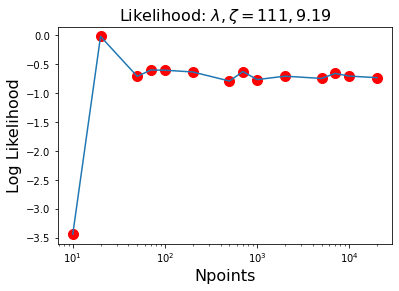

In [25]:
# given the true values, mass and redshift
# plot the likelihood around the true y-values (lambda, zeta)

plt.xscale('log')
plt.plot(npoints, likes)
plt.scatter(npoints, likes, color='r', s=100)
plt.xlabel(r'Npoints',fontsize=16)
plt.ylabel('Log Likelihood',fontsize=16)
plt.title(r'Likelihood: $\lambda, \zeta = %i, %.2f$'%(_lbd, _zeta),fontsize=16)

We should see the integral values converging to a stable value after a given number of points. If we don't see this behaviour it's because the integral didn't converge.

- Try with a larger number and more points
- Time how much seconds it takes for each integration
- Play with halo mass values 

In [26]:
### NEW WORK ###

In [27]:
# set some initial parameteres 
_theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

## change here! halo mass between 3e14 up to 2e15
_M = 4e14 # log mass
_z = 0.5 # redshift

_lbd, _zeta = np.exp(prediction(_theta, _M, _z)).T
_xi = to_xi(_zeta)

# errors
_lbd_err = 10**(0.1*np.log10(_lbd))
_zeta_err = 10**(0.04*np.log10(_zeta))

npoints=1
x1 = np.tile(_lbd,npoints)
x2 = np.tile(_xi,npoints)

x1_err = np.tile(_lbd_err,npoints)
x2_err = np.tile(_zeta_err,npoints)


M = np.tile(_M,npoints)
z = np.tile(_z,npoints)
theta = _theta

# print('Initial variables')
# print('lambda, zeta = %i, %.1f'%(_lbd[0], _zeta[0]))

In [28]:
# npoints = np.array([10, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000])
npoints = np.array([10, 20, 50, 70, 100, 200, 500, 700, 1000, 2000, 5000, 7000, 10000, 20000, 50000, 70000])
npoints

array([   10,    20,    50,    70,   100,   200,   500,   700,  1000,
        2000,  5000,  7000, 10000, 20000, 50000, 70000])

In [29]:
## showing the convergence for random integers for the specific nsize
import time
from datetime import datetime
time_for_now = datetime.now()
likes = []
res = []
err = []
for nsize in npoints:
    ## USED TO SEE HOW LONG IT TAKES TO FIND THE LIKELIHOOD FOR EACH SIZE OF N (NSIZE)
    start = time.time()
    idx = np.random.randint(nsize)
    # Integration is equal to np.mean(mc_likelihood(theta, z, x1, x2, x1_err, x2_err, Npoints=nsize))
    I = np.mean(mc_likelihood(theta, z, x1, x2, x1_err, x2_err, Npoints=nsize))
    res.append(I)
    end = time.time()
    spt_time = end - start
    print("SPT Model took {0:.1f} seconds".format(spt_time), "to process an nsize of", nsize)
    # Errors are recorded for each calculated integration result
    err.append(np.std(res))
    #likes.append(mc_likelihood(theta, z, x1, x2, x1_err, x2_err, Npoints=nsize))

print("Current result:", res)

SPT Model took 0.0 seconds to process an nsize of 10
SPT Model took 0.0 seconds to process an nsize of 20
SPT Model took 0.0 seconds to process an nsize of 50
SPT Model took 0.0 seconds to process an nsize of 70
SPT Model took 0.1 seconds to process an nsize of 100
SPT Model took 0.2 seconds to process an nsize of 200
SPT Model took 0.3 seconds to process an nsize of 500
SPT Model took 0.4 seconds to process an nsize of 700
SPT Model took 0.7 seconds to process an nsize of 1000
SPT Model took 1.6 seconds to process an nsize of 2000
SPT Model took 5.2 seconds to process an nsize of 5000
SPT Model took 8.2 seconds to process an nsize of 7000
SPT Model took 13.6 seconds to process an nsize of 10000
SPT Model took 43.4 seconds to process an nsize of 20000
SPT Model took 233.8 seconds to process an nsize of 50000
SPT Model took 457.5 seconds to process an nsize of 70000
Current result: [-1.4306209589237193, 0.16152644446330683, -0.5419330072940928, -0.98340141064033, -0.8218709306925284, -1

In [ ]:
print("Current error margin for every nsize: ", err)

In [30]:
## Given error for every integration calculation based upon the standard deviation
#err = []
#err = np.std(res)
add_err = []
for size in err:
        add_err.append(err/I)

print("Current error/I for every nsize: ", add_err)

Current error margin for every nsize:  [0.0, 0.7960737016935131, 0.651456046931328, 0.5876496776706458, 0.5279173658786488, 0.508698559746265, 0.4849508915158809, 0.4546936850022537, 0.4287079468083983, 0.4077625156296086, 0.38882749035353203, 0.37228601411114853, 0.35782992270557673, 0.3448644406902628, 0.3331821130769645, 0.32266265257911364]
Current error/I for every nsize:  [array([-0.        , -1.14257664, -0.93501199, -0.84343295, -0.75770126,
       -0.73011718, -0.69603299, -0.65260588, -0.61530947, -0.58524722,
       -0.55807045, -0.53432905, -0.51358073, -0.49497182, -0.47820459,
       -0.46310638]), array([-0.        , -1.14257664, -0.93501199, -0.84343295, -0.75770126,
       -0.73011718, -0.69603299, -0.65260588, -0.61530947, -0.58524722,
       -0.55807045, -0.53432905, -0.51358073, -0.49497182, -0.47820459,
       -0.46310638]), array([-0.        , -1.14257664, -0.93501199, -0.84343295, -0.75770126,
       -0.73011718, -0.69603299, -0.65260588, -0.61530947, -0.58524722

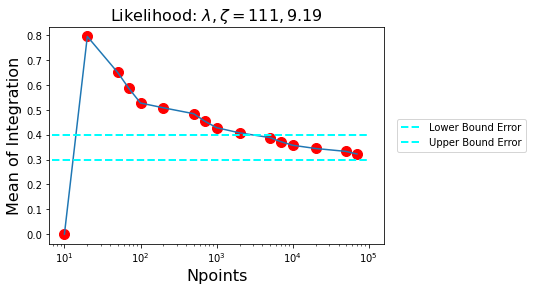

In [33]:
plt.xscale('log')
plt.plot(npoints, err)
plt.scatter(npoints, err, color='r', s=100)
plt.xlabel(r'Npoints',fontsize=16)
plt.ylabel('Mean of Integration',fontsize=16)
plt.title(r'Likelihood: $\lambda, \zeta = %i, %.2f$'%(_lbd, _zeta),fontsize=16)

plt.hlines(y=0.3, xmin=0, xmax=100000, colors='aqua', linestyles='--', lw=2, label='Lower Bound Error')
plt.hlines(y=0.4, xmin=0, xmax=100000, colors='aqua', linestyles='--', lw=2, label='Upper Bound Error')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)